In [1]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Hallo leute! Today’s post we will implement the awesome model to learn word embeddings Glove: Global Vectors for Word Representation, using Pytorch. Developed by Stanford, the main idea is to leverage the matrix of word cooccurrences in order to extract “dimensions of meaning”, outputing word vectors that naturally captures word semantics and thus being useful representations in a lot of tasks, such word analogies. You can find more information in the original paper here .

For this project, we will use the text8 dataset (that can be download here). This dataset is a dump of cleaned wikipedia texts. More details here .

First, we just import the necessary libs.

In [2]:
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE

Next we will create a dataset class to manage our feature extraction and batch generation. We must create a cooccurence matrix for every word to feed the glove model. We will generate a vocab of ~190k words. If we create a common matrix, it would have 190000² entries, which would result in ~36 billion entries. If we consider each value a 32bit integer, we are talking of ~135GB of memory, too much to store and process. To handle this issue we can leverage the fact that most of the entries of this matrix are 0 so we just need to store the non-zero values, which drastically reduce the amount of memory necessary.

In [3]:
english_text_python_program_pair_list = []
process_python_code=False
i=1
with open('dataset_python_cleaned_final.txt', 'r', encoding="utf8") as f:
    for line in f:
        #print(i)
        i += 1
        if process_python_code==False:
            if line.strip() == '':
                continue
            if line.startswith('#'):
                english_text = line
                #english_text_list.append(line)
                process_python_code=True
                python_program=''
            else:
                print(i, ": ", line)            
        else:
            if line.strip() == '':
                process_python_code=False
                english_text_python_program_pair_list.append((english_text, python_program))
                python_program=''
                english_text =''
            if line.lstrip().startswith('#'):
                continue
            else:
                python_program += line

In [4]:
len(english_text_python_program_pair_list)

4727

In [5]:
import json
# Opening JSON file 
with open('conala-corpus/conala-combined.json') as f: 
    # returns JSON object as  
    # a dictionary 
    data = json.load(f) 
    for record in data:
        english_text_python_program_pair_list.append((record['intent'],record['snippet'] ))

In [6]:
print(english_text_python_program_pair_list)

[('# write a python program to add two numbers \n', "num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\nprint(f'Sum: {sum}')\n"), ('# write a python function to add two user provided numbers and return the sum\n', 'def add_two_numbers(num1, num2):\n    sum = num1 + num2\n    return sum\n'), ('# write a program to find and print the largest among three numbers\n', "num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >= num2) and (num1 >= num3):\n   largest = num1\nelif (num2 >= num1) and (num2 >= num3):\n   largest = num2\nelse:\n   largest = num3\nprint(f'largest:{largest}')\n"), ('# write a program to find and print the smallest among three numbers\n', "num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= num2) and (num1 <= num3):\n   smallest = num1\nelif (num2 <= num1) and (num2 <= num3):\n   smallest = num2\nelse:\n   smallest = num3\nprint(f'smallest:{smallest}')\n"), ('# Write a python function to merge two given lists into one\n', 'def merge_lists(l1, l2):\n    return l1 + l2\n'), ('# Write a program to 

In [7]:
english_text_list,python_program_list  = zip(*english_text_python_program_pair_list)

In [8]:
python_program_list

("num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\nprint(f'Sum: {sum}')\n",
 'def add_two_numbers(num1, num2):\n    sum = num1 + num2\n    return sum\n',
 "num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >= num2) and (num1 >= num3):\n   largest = num1\nelif (num2 >= num1) and (num2 >= num3):\n   largest = num2\nelse:\n   largest = num3\nprint(f'largest:{largest}')\n",
 "num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= num2) and (num1 <= num3):\n   smallest = num1\nelif (num2 <= num1) and (num2 <= num3):\n   smallest = num2\nelse:\n   smallest = num3\nprint(f'smallest:{smallest}')\n",
 'def merge_lists(l1, l2):\n    return l1 + l2\n',
 'num = 337\nif num > 1:\n   for i in range(2, num//2 + 1):\n       if (num % i) == 0:\n           print(num,"is not a prime number")\n           print(f"{i} times {num//i} is {num}")\n           break\n   else:\n       print(f"{num} is a prime number")\nelse:\n   print(f"{num} is not a prime number")\n',
 'def print_factors(x):\n   print(f"The factors of {x} are:")\n   f

In [10]:
import pandas as pd

df = pd.DataFrame({'English': english_text_list, 'Python':python_program_list })

In [11]:
df['Python'].head(10)

0    num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...
1    def add_two_numbers(num1, num2):\n    sum = nu...
2    num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >= n...
3    num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...
4       def merge_lists(l1, l2):\n    return l1 + l2\n
5    num = 337\nif num > 1:\n   for i in range(2, n...
6    def print_factors(x):\n   print(f"The factors ...
7    num = 13\nfactorial = 1\nif num < 0:\n   print...
8    def check_pnz(num):\n    if num > 0:\n       p...
9    num = 9\nfor i in range(1, 11):\n   print(f"{n...
Name: Python, dtype: object

In [12]:
len(english_text_python_program_pair_list)

7606

In [13]:
import tokenize
import io
s = python_program_list[1]
tokens = tokenize.tokenize(io.BytesIO(s.encode('utf-8')).readline)
for five_tuple in tokens:
    print(five_tuple.type, five_tuple.string)

57 utf-8
1 def
1 add_two_numbers
53 (
1 num1
53 ,
1 num2
53 )
53 :
4 

5     
1 sum
53 =
1 num1
53 +
1 num2
4 

1 return
1 sum
4 

6 
0 


In [15]:
dir(tokenize)

['AMPER',
 'AMPEREQUAL',
 'AT',
 'ATEQUAL',
 'BOM_UTF8',
 'Binnumber',
 'Bracket',
 'CIRCUMFLEX',
 'CIRCUMFLEXEQUAL',
 'COLON',
 'COMMA',
 'COMMENT',
 'Comment',
 'ContStr',
 'DEDENT',
 'DOT',
 'DOUBLESLASH',
 'DOUBLESLASHEQUAL',
 'DOUBLESTAR',
 'DOUBLESTAREQUAL',
 'Decnumber',
 'Double',
 'Double3',
 'ELLIPSIS',
 'ENCODING',
 'ENDMARKER',
 'EQEQUAL',
 'EQUAL',
 'ERRORTOKEN',
 'EXACT_TOKEN_TYPES',
 'Expfloat',
 'Exponent',
 'Floatnumber',
 'Funny',
 'GREATER',
 'GREATEREQUAL',
 'Hexnumber',
 'INDENT',
 'ISEOF',
 'ISNONTERMINAL',
 'ISTERMINAL',
 'Ignore',
 'Imagnumber',
 'Intnumber',
 'LBRACE',
 'LEFTSHIFT',
 'LEFTSHIFTEQUAL',
 'LESS',
 'LESSEQUAL',
 'LPAR',
 'LSQB',
 'MINEQUAL',
 'MINUS',
 'NAME',
 'NEWLINE',
 'NL',
 'NOTEQUAL',
 'NT_OFFSET',
 'NUMBER',
 'N_TOKENS',
 'Name',
 'Number',
 'OP',
 'Octnumber',
 'Operator',
 'PERCENT',
 'PERCENTEQUAL',
 'PLUS',
 'PLUSEQUAL',
 'PlainToken',
 'Pointfloat',
 'PseudoExtras',
 'PseudoToken',
 'RARROW',
 'RBRACE',
 'RIGHTSHIFT',
 'RIGHTSHIFTEQUAL

In [16]:
import tokenize
import io

python_token_list = []

j = 0
for python_program in python_program_list:
    raised_exception = False
    #print(j)
    try:
        tokens = tokenize.tokenize(io.BytesIO(python_program.encode('utf-8')).readline)
        for five_tuple in tokens:
            if five_tuple.type == tokenize.COMMENT:
                continue
            elif five_tuple.type == tokenize.ENCODING:
                python_token_list.append('<sos>')
            elif five_tuple.type == tokenize.INDENT:
                python_token_list.append("INDENT")
            elif five_tuple.type == tokenize.DEDENT:
                python_token_list.append("DEDENT")
            elif five_tuple.type == tokenize.NL or five_tuple.type == tokenize.NEWLINE:
                python_token_list.append("NEWLINE")
            elif five_tuple.type == tokenize.ENDMARKER :
                python_token_list.append("<eos>")
            else:
                python_token_list.append(five_tuple.string)
    except Exception:
        raised_exception = True
        print("j: ", j, " Exception: ", Exception, " program: ", python_program)
    j +=1
        

In [17]:
class GloveDataset:

  def __init__(self, python_token_list, n_words=200000, window_size=5):
      self._window_size = window_size
      self._tokens = python_token_list[:n_words]
      word_counter = Counter()
      word_counter.update(self._tokens)
      self._word2id = {w:i for i, (w,_) in enumerate(word_counter.most_common())}
      self._id2word = {i:w for w, i in self._word2id.items()}
      self._vocab_len = len(self._word2id)

      self._id_tokens = [self._word2id[w] for w in self._tokens]

      self._create_coocurrence_matrix()

      print("# of words: {}".format(len(self._tokens)))
      print("Vocabulary length: {}".format(self._vocab_len))

  def _create_coocurrence_matrix(self):
      cooc_mat = defaultdict(Counter)
      for i, w in enumerate(self._id_tokens):
          start_i = max(i - self._window_size, 0)
          end_i = min(i + self._window_size + 1, len(self._id_tokens))
          for j in range(start_i, end_i):
              if i != j:
                  c = self._id_tokens[j]
                  cooc_mat[w][c] += 1 / abs(j-i)

      self._i_idx = list()
      self._j_idx = list()
      self._xij = list()

      #Create indexes and x values tensors
      for w, cnt in cooc_mat.items():
          for c, v in cnt.items():
              self._i_idx.append(w)
              self._j_idx.append(c)
              self._xij.append(v)

      self._i_idx = torch.LongTensor(self._i_idx).cuda()
      self._j_idx = torch.LongTensor(self._j_idx).cuda()
      self._xij = torch.FloatTensor(self._xij).cuda()


  def get_batches(self, batch_size):
      #Generate random idx
      rand_ids = torch.LongTensor(np.random.choice(len(self._xij), len(self._xij), replace=False))

      for p in range(0, len(rand_ids), batch_size):
          batch_ids = rand_ids[p:p+batch_size]
          yield self._xij[batch_ids], self._i_idx[batch_ids], self._j_idx[batch_ids]

dataset = GloveDataset(python_token_list, 10000000)

# of words: 307052
Vocabulary length: 8644


Here we create the class of our glove model. In its forward pass it will perform the yellow part of the Glove loss function, described in the original paper:

![](https://cdn.hashnode.com/res/hashnode/image/upload/v1587152473299/6HedPZypj.png?auto=compress)


In [18]:
EMBED_DIM = 300
class GloveModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(GloveModel, self).__init__()
        self.wi = nn.Embedding(num_embeddings, embedding_dim)
        self.wj = nn.Embedding(num_embeddings, embedding_dim)
        self.bi = nn.Embedding(num_embeddings, 1)
        self.bj = nn.Embedding(num_embeddings, 1)

        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()

    def forward(self, i_indices, j_indices):
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()

        x = torch.sum(w_i * w_j, dim=1) + b_i + b_j

        return x
glove = GloveModel(dataset._vocab_len, EMBED_DIM)
glove.cuda()


GloveModel(
  (wi): Embedding(8644, 300)
  (wj): Embedding(8644, 300)
  (bi): Embedding(8644, 1)
  (bj): Embedding(8644, 1)
)

We must define a function to compute the weighting term f(Xij) of the loss function as per described in the paper:


![](https://cdn.hashnode.com/res/hashnode/image/upload/v1587152743199/bjCyXW0Wc.png?auto=compress)


In [19]:
def weight_func(x, x_max, alpha):
    wx = (x/x_max)**alpha
    wx = torch.min(wx, torch.ones_like(wx))
    return wx.cuda()


The loss function described in the Glove paper is a weighted mean squared error. Pytorch 1.0 doesn’t have implementation for it, so we must write it ourselves. A good practice is to reuse any piece of this function already implemented so we take advantage of any optimization it might have:

In [20]:
def wmse_loss(weights, inputs, targets):
    loss = weights * F.mse_loss(inputs, targets, reduction='none')
    return torch.mean(loss).cuda()


Although we are using a diferent configuration (like the dataset) of the original paper, we will use the same optimizer and learning rate it describes.

In [21]:
optimizer = optim.Adagrad(glove.parameters(), lr=0.05)


Now we can write our training loop. The ALPHA and X_MAX parameters are set accoring to the paper. We also save our model states every 100 epochs.

In [22]:
N_EPOCHS = 50
BATCH_SIZE = 512
X_MAX = 100
ALPHA = 0.75
n_batches = int(len(dataset._xij) / BATCH_SIZE)
loss_values = list()
for e in range(1, N_EPOCHS+1):
    batch_i = 0

    for x_ij, i_idx, j_idx in dataset.get_batches(BATCH_SIZE):

        batch_i += 1

        optimizer.zero_grad()

        outputs = glove(i_idx, j_idx)
        weights_x = weight_func(x_ij, X_MAX, ALPHA)
        loss = wmse_loss(weights_x, outputs, torch.log(x_ij))

        loss.backward()

        optimizer.step()

        loss_values.append(loss.item())

        if batch_i % 100 == 0:
            print("Epoch: {}/{} \t Batch: {}/{} \t Loss: {}".format(e, N_EPOCHS, batch_i, n_batches, np.mean(loss_values[-20:])))  

    print("Saving model...")
    torch.save(glove.state_dict(), "glove_combined_300.pt")


Epoch: 1/50 	 Batch: 100/423 	 Loss: 1.816418355703354
Epoch: 1/50 	 Batch: 200/423 	 Loss: 1.8992996752262115
Epoch: 1/50 	 Batch: 300/423 	 Loss: 1.6994117379188538
Epoch: 1/50 	 Batch: 400/423 	 Loss: 1.6083867490291595
Saving model...
Epoch: 2/50 	 Batch: 100/423 	 Loss: 0.5815859749913216
Epoch: 2/50 	 Batch: 200/423 	 Loss: 0.5401847332715988
Epoch: 2/50 	 Batch: 300/423 	 Loss: 0.556768947839737
Epoch: 2/50 	 Batch: 400/423 	 Loss: 0.5015668705105781
Saving model...
Epoch: 3/50 	 Batch: 100/423 	 Loss: 0.3031293645501137
Epoch: 3/50 	 Batch: 200/423 	 Loss: 0.27278156131505965
Epoch: 3/50 	 Batch: 300/423 	 Loss: 0.28557624444365504
Epoch: 3/50 	 Batch: 400/423 	 Loss: 0.2751690074801445
Saving model...
Epoch: 4/50 	 Batch: 100/423 	 Loss: 0.1906801328063011
Epoch: 4/50 	 Batch: 200/423 	 Loss: 0.18647696301341057
Epoch: 4/50 	 Batch: 300/423 	 Loss: 0.19197270050644874
Epoch: 4/50 	 Batch: 400/423 	 Loss: 0.18624967634677886
Saving model...
Epoch: 5/50 	 Batch: 100/423 	 Loss: 

Epoch: 34/50 	 Batch: 100/423 	 Loss: 0.009903157013468444
Epoch: 34/50 	 Batch: 200/423 	 Loss: 0.00930663903709501
Epoch: 34/50 	 Batch: 300/423 	 Loss: 0.008307469054125249
Epoch: 34/50 	 Batch: 400/423 	 Loss: 0.009416258498094975
Saving model...
Epoch: 35/50 	 Batch: 100/423 	 Loss: 0.009797757677733897
Epoch: 35/50 	 Batch: 200/423 	 Loss: 0.009709577984176576
Epoch: 35/50 	 Batch: 300/423 	 Loss: 0.008738547074608504
Epoch: 35/50 	 Batch: 400/423 	 Loss: 0.00886020266916603
Saving model...
Epoch: 36/50 	 Batch: 100/423 	 Loss: 0.009029830200597644
Epoch: 36/50 	 Batch: 200/423 	 Loss: 0.009319203579798341
Epoch: 36/50 	 Batch: 300/423 	 Loss: 0.008723359904251993
Epoch: 36/50 	 Batch: 400/423 	 Loss: 0.008257310860790313
Saving model...
Epoch: 37/50 	 Batch: 100/423 	 Loss: 0.007857206370681524
Epoch: 37/50 	 Batch: 200/423 	 Loss: 0.008738899906165897
Epoch: 37/50 	 Batch: 300/423 	 Loss: 0.009067334281280637
Epoch: 37/50 	 Batch: 400/423 	 Loss: 0.008316739508882166
Saving mod

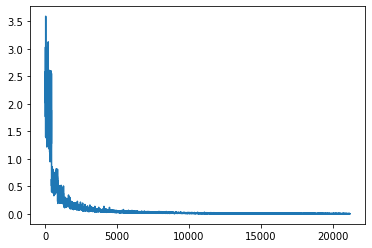

In [23]:
plt.plot(loss_values)

Here we sum over the two embedding matrices (as per recommendation of the original paper) to improve results. We then plot the TSNE space of the top 300 words to validate our word embeddings.

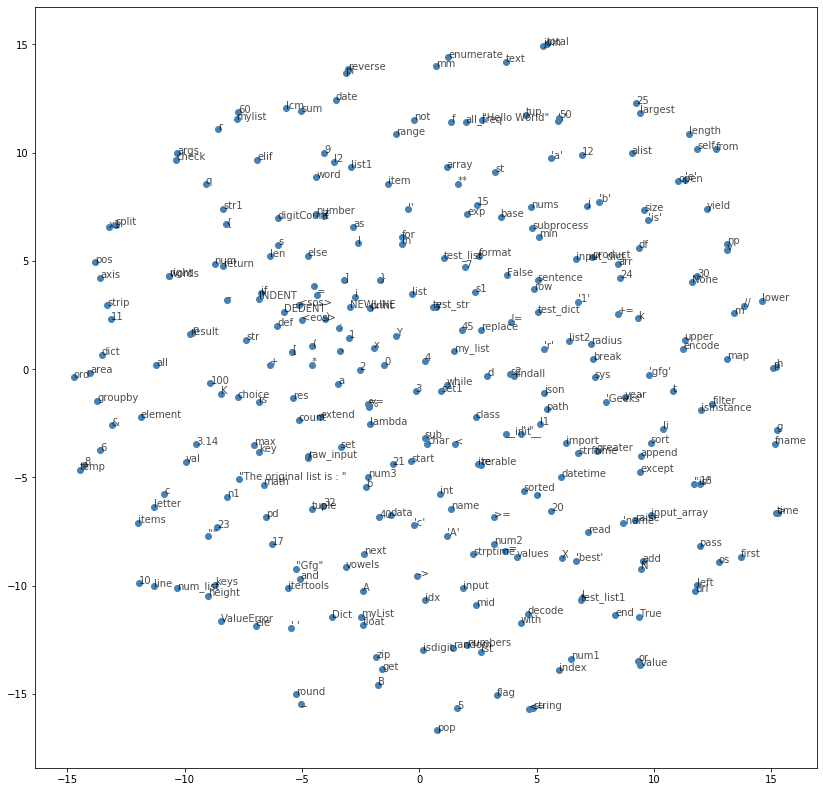

In [24]:
emb_i = glove.wi.weight.cpu().data.numpy()
emb_j = glove.wj.weight.cpu().data.numpy()
emb = emb_i + emb_j
top_k = 300
tsne = TSNE(metric='cosine', random_state=123)
embed_tsne = tsne.fit_transform(emb[:top_k, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(top_k):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(dataset._id2word[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)


In [25]:
glove_model = GloveModel(dataset._vocab_len, EMBED_DIM)
glove_model.load_state_dict(torch.load('glove_combined_300.pt'))


<All keys matched successfully>

In [26]:
dir(glove_model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_module',
 'apply',
 'bi',
 'bj',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'half',
 'load_state_dict',
 'modules',
 'na

In [27]:
glove_model.state_dict()

OrderedDict([('wi.weight',
              tensor([[ 0.7141, -0.5699,  0.6148,  ..., -0.2378,  0.0612, -0.4138],
                      [ 0.0998, -0.1031, -0.5039,  ..., -0.7072,  0.3936,  0.2034],
                      [ 0.0063, -0.2022,  0.3528,  ..., -0.0899, -0.2607,  0.4447],
                      ...,
                      [-0.0470, -0.8034, -0.2445,  ..., -0.5978,  0.2009, -1.0621],
                      [-0.7512,  0.7081, -0.6949,  ...,  0.6904, -0.2997,  0.0269],
                      [ 0.0668,  0.6468, -0.3930,  ..., -0.8792, -0.0698, -0.0575]])),
             ('wj.weight',
              tensor([[-0.0029, -0.6679,  0.5747,  ...,  0.4212,  0.5474,  0.6308],
                      [ 0.4238, -0.5826,  0.5417,  ..., -0.1176,  0.2498,  0.1568],
                      [-0.0039, -0.3061,  0.5403,  ..., -0.3254,  0.4677, -0.1525],
                      ...,
                      [ 0.2207, -0.6466,  0.0516,  ...,  0.9490, -0.0240,  0.6293],
                      [ 0.4187, -0.6509, -0.6604,

Checking the words that are close, we can say that our model performs pretty good! We can check that it clusters the direction words north, south, west, east and even central. It also clusters together words with their plural form like system/systems and language/languages.

In [28]:
glove_model.state_dict()['wi.weight']

tensor([[ 0.7141, -0.5699,  0.6148,  ..., -0.2378,  0.0612, -0.4138],
        [ 0.0998, -0.1031, -0.5039,  ..., -0.7072,  0.3936,  0.2034],
        [ 0.0063, -0.2022,  0.3528,  ..., -0.0899, -0.2607,  0.4447],
        ...,
        [-0.0470, -0.8034, -0.2445,  ..., -0.5978,  0.2009, -1.0621],
        [-0.7512,  0.7081, -0.6949,  ...,  0.6904, -0.2997,  0.0269],
        [ 0.0668,  0.6468, -0.3930,  ..., -0.8792, -0.0698, -0.0575]])

In [29]:
dataset._word2id

{'NEWLINE': 0,
 '(': 1,
 ')': 2,
 ',': 3,
 ':': 4,
 '=': 5,
 'INDENT': 6,
 'DEDENT': 7,
 '[': 8,
 ']': 9,
 '<sos>': 10,
 '<eos>': 11,
 '.': 12,
 'print': 13,
 '1': 14,
 'in': 15,
 'i': 16,
 'for': 17,
 '0': 18,
 'def': 19,
 'return': 20,
 'x': 21,
 'if': 22,
 '2': 23,
 '+': 24,
 '-': 25,
 'n': 26,
 'a': 27,
 '==': 28,
 '*': 29,
 '3': 30,
 'len': 31,
 'range': 32,
 '5': 33,
 '4': 34,
 'str': 35,
 '{': 36,
 '}': 37,
 'j': 38,
 'else': 39,
 's': 40,
 'res': 41,
 'num': 42,
 'import': 43,
 'key': 44,
 'self': 45,
 'list': 46,
 '%': 47,
 'b': 48,
 'str1': 49,
 '6': 50,
 'd': 51,
 '10': 52,
 'int': 53,
 'k': 54,
 'y': 55,
 '7': 56,
 'float': 57,
 'test_list': 58,
 '+=': 59,
 '/': 60,
 'count': 61,
 '8': 62,
 'l': 63,
 'result': 64,
 'input': 65,
 '**': 66,
 '>': 67,
 'append': 68,
 'arr': 69,
 'sum': 70,
 'alist': 71,
 'list1': 72,
 'c': 73,
 'lambda': 74,
 'True': 75,
 're': 76,
 '<': 77,
 '9': 78,
 'random': 79,
 'while': 80,
 'split': 81,
 'word': 82,
 'datetime': 83,
 'items': 84,
 'df':

In [31]:
dataset._word2id['def']

19

In [32]:
glove_model.state_dict()['wi.weight'][dataset._word2id['def']] + glove_model.state_dict()['wj.weight'][dataset._word2id['def']]

tensor([-0.1429,  0.3316, -0.1894,  0.1846, -0.0776, -0.3939,  0.7386,  0.1847,
        -0.7436,  0.2098, -0.0857,  0.1845,  0.3548, -0.6453,  0.5214,  0.6422,
        -0.9664,  0.5978,  0.5039,  0.2324,  0.6759, -1.3122,  0.5002,  1.2406,
         0.1455, -0.0866, -0.9861, -0.0563,  0.3866,  0.3920, -0.8892, -0.7403,
        -0.8660, -0.8088, -0.3619,  0.3839,  0.1406, -0.8047,  0.5937, -0.2730,
         0.5783, -0.6186,  0.8880,  0.1787,  0.2987, -0.2541, -1.1860,  0.2440,
        -0.7495, -0.2765, -0.6831,  0.1665,  0.2708,  0.5058, -0.3022,  1.0246,
         0.5844,  0.4181, -0.3001,  0.1130, -0.8262,  0.5757,  0.1256, -0.6736,
        -0.2157,  0.1185, -0.5062, -0.2140, -0.1581, -0.0883,  0.0131,  0.0658,
        -0.1738, -0.2636,  0.0153, -0.6637, -0.6599, -0.3500,  0.4954,  0.2023,
         0.3241,  0.4508, -0.2932,  0.1415, -0.8246, -0.0579,  0.4369, -0.5699,
        -0.1392, -0.3981, -0.5536,  0.3926, -0.4563, -0.0483, -0.0457, -0.1352,
        -0.0535, -0.4233,  0.9858,  0.57

In [34]:
import pickle
with open('combined_dataset_vocab_300.pkl', 'wb') as tokens: 
    pickle.dump(dataset._word2id, tokens)

In [36]:
object_dict = None
with open('combined_dataset_vocab_300.pkl',  'rb' ) as f:
    object_dict = pickle.load(f)

In [37]:
object_dict

{'NEWLINE': 0,
 '(': 1,
 ')': 2,
 ',': 3,
 ':': 4,
 '=': 5,
 'INDENT': 6,
 'DEDENT': 7,
 '[': 8,
 ']': 9,
 '<sos>': 10,
 '<eos>': 11,
 '.': 12,
 'print': 13,
 '1': 14,
 'in': 15,
 'i': 16,
 'for': 17,
 '0': 18,
 'def': 19,
 'return': 20,
 'x': 21,
 'if': 22,
 '2': 23,
 '+': 24,
 '-': 25,
 'n': 26,
 'a': 27,
 '==': 28,
 '*': 29,
 '3': 30,
 'len': 31,
 'range': 32,
 '5': 33,
 '4': 34,
 'str': 35,
 '{': 36,
 '}': 37,
 'j': 38,
 'else': 39,
 's': 40,
 'res': 41,
 'num': 42,
 'import': 43,
 'key': 44,
 'self': 45,
 'list': 46,
 '%': 47,
 'b': 48,
 'str1': 49,
 '6': 50,
 'd': 51,
 '10': 52,
 'int': 53,
 'k': 54,
 'y': 55,
 '7': 56,
 'float': 57,
 'test_list': 58,
 '+=': 59,
 '/': 60,
 'count': 61,
 '8': 62,
 'l': 63,
 'result': 64,
 'input': 65,
 '**': 66,
 '>': 67,
 'append': 68,
 'arr': 69,
 'sum': 70,
 'alist': 71,
 'list1': 72,
 'c': 73,
 'lambda': 74,
 'True': 75,
 're': 76,
 '<': 77,
 '9': 78,
 'random': 79,
 'while': 80,
 'split': 81,
 'word': 82,
 'datetime': 83,
 'items': 84,
 'df':

In [38]:
import torch
import torchvision
import torchtext

In [40]:
torch.__version__

'1.4.0'

In [41]:
torchvision.__version__

'0.5.0'

In [42]:
torchtext.__version__

'0.6.0'